In [147]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Ajoute le dossier "src" au path
src_path = os.path.abspath("..")
if src_path not in sys.path:
    sys.path.append(src_path)
	
# Data manipulation
import pandas as pd
from pandas import DataFrame

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Reducer
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.model_selection import train_test_split
import re
import emoji

# Models fine tuning
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV

import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
# Custom
import importlib
from utils.result_helper import save_result, display_result
import utils.helper as helper 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Importation of the dataset

In [168]:
importlib.reload(helper)

nlp = helper.load_nlp_model()
config:helper.Step1Config = helper.ConfigLoader.load_step1()

df_path= "../../scitweets.tsv"
df_base = pd.read_csv(df_path, sep='\t', header=0)

df_base = df_base.drop(columns=[col for col in df_base.columns if "Unnamed" in col] + ["tweet_id"])
df_base["text"] = df_base["text"].astype(str)

## Preprocessing
1. On définit les préprocessings de la donnée

In [149]:
def emoji_processing(X: DataFrame) -> DataFrame:
	def count_emojis(text: str) -> int:
		return sum(1 for char in text if char in emoji.EMOJI_DATA)

	def replace_emojis(text: str) -> str:
		return emoji.demojize(text, delimiters=(" ", " "))
	
	X = X.copy()
	X["emoji_count"] = X["text"].apply(count_emojis)
	X["text"] = X["text"].apply(replace_emojis)
	return X
	
def link_processing(X: DataFrame) -> DataFrame:
	def count_links(text: str) -> int:
		return len(re.findall(r'https?:\/\/.*[\r\n]*', text))

	def replace_link(text: str) -> str:
		return re.sub(r'https?:\/\/\S+', '[url]', text)
	
	X["link_count"] = X["text"].apply(count_links)
	X["text"] = X["text"].apply(replace_link)
	return X

def hashtag_processing(X: DataFrame) -> DataFrame:
    def extract_hashtags(text: str) -> list:
        return re.findall(r'#(\w+)', text)
    
    def count_hashtags(text: str) -> int:
        return len(re.findall(r'#\w+', text))
    
    def replace_hashtags(text: str) -> str:
        return re.sub(r'#(\w+)', r'\1', text)
    
    X = X.copy()
    X["hashtag_count"] = X["text"].apply(count_hashtags)
    
	# On fait une listes de hashtags les plus utiliser 
    hashtags_series = X["text"].apply(extract_hashtags)
    hashtags_list = [tag for sublist in hashtags_series for tag in sublist]
    top_hashtags = pd.Series(hashtags_list).value_counts().head(20).index.tolist()
    
    for tag in top_hashtags:
        X[f"has_hashtag_{tag}"] = X["text"].apply(lambda x: 1 if f'#{tag}' in x.lower() else 0)
    
    X["text"] = X["text"].apply(replace_hashtags)
    
    return X

def mention_processing(X: DataFrame) -> DataFrame:
    def count_mentions(text: str) -> int:
        return len(re.findall(r'@\w+', text))
    
    def replace_mentions(text: str) -> str:
        return re.sub(r'@\w+', '[mention]', text)

    X = X.copy()
    X["mention_count"] = X["text"].apply(count_mentions)
    X["text"] = X["text"].apply(replace_mentions)
    return X

def number_processing(X: DataFrame) -> DataFrame:
    X = X.copy()
    X["numbers_count"] = X["text"].apply(lambda x: len(re.findall(r'\d+', x)))
    return X

def keyword_features(X: DataFrame) -> DataFrame:
    """D'après mon analyse de données, nous avons des mots très discriminants, j'en ai donc fait des features"""
    X = X.copy()
    
    science_keywords = ["study", "research", "health", "science", "cancer", "brain", "climate", "risk"]
    non_science_keywords = ["stop", "support", "reports", "please", "need", "today", "trump"]
    
    for word in science_keywords:
        X[f"has_sci_{word}"] = X["text"].apply(lambda x: 1 if re.search(r'\b' + word + r'\b', x.lower()) else 0)
    
    for word in non_science_keywords:
        X[f"has_nonsci_{word}"] = X["text"].apply(lambda x: 1 if re.search(r'\b' + word + r'\b', x.lower()) else 0)
    
    return X

def pre_processing(X: DataFrame) -> DataFrame:
	def preprocess(text):
		doc = nlp(text.lower())
		return " ".join(token.lemma_ for token in doc if not token.is_stop and not token.is_punct)

	X = X.copy()
	X["text"] = X["text"].apply(preprocess)
	return X

2. On pre-processed le data
   
C'est très facile d'activer ou désactiver une feature

In [150]:
df = df_base.copy()
df = emoji_processing(df)
df = link_processing(df)
df = number_processing(df)
# df = mention_processing(df)
df = hashtag_processing(df)
df = keyword_features(df)
df = pre_processing(df)

In [151]:
X = df.copy().drop(columns=["scientific_claim", "scientific_reference", "scientific_context"])
y = X.pop("science_related")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.random_state, test_size=config.test_ratio)

X_train.head()

,text,emoji_count,link_count,numbers_count,hashtag_count,has_hashtag_EurekaMag,has_hashtag_COVID19,has_hashtag_jobs,has_hashtag_science,has_hashtag_ClimateChange,...,has_sci_brain,has_sci_climate,has_sci_risk,has_nonsci_stop,has_nonsci_support,has_nonsci_reports,has_nonsci_please,has_nonsci_need,has_nonsci_today,has_nonsci_trump
867,@drolufunmilayo smoking cannabis help control ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
831,kid wear sunglass support classmate battle eye...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1057,@csrv @jay4profit thank yes reaction lead big ...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1118,kaiser stop lurk useless expect tribute 10 min...,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
654,$ imgn immunogen report recent progress quarte...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


# Evaluation des classifiers sans tunning avec TF-IDF & Bag of words

On va utiliser une classe python, qui va essayer a tour de role, les classifiers sans tuning des paramètres, d'abord avec une vectorisation TF-IDF puis avec Bag of words.

On a choisit la validation croisée sur le training set pour estimer la performance et la variabilité des modèles et de selectionner les plus prometteur.

In [152]:
import classification_2classe.evaluation_classifiers as evaluation_classifiers
importlib.reload(evaluation_classifiers)

evaluator = evaluation_classifiers.ClassifierEvaluation(X_train, y_train, X_test, y_test)
results, sorted_results = evaluator.evaluate()

 
=== CLASSEMENT DES MODÈLES (par F1-score) ===
ℹ️  1. Naive Bayes avec Bag of words
   F1-score: 0.7705 ± 0.0328
   Accuracy: 0.8004 ± 0.0294
ℹ️  2. Naive Bayes avec TF-IDF
   F1-score: 0.7594 ± 0.0368
   Accuracy: 0.8070 ± 0.0275
ℹ️  3. Régression Logistique avec TF-IDF
   F1-score: 0.7561 ± 0.0160
   Accuracy: 0.8070 ± 0.0120
ℹ️  4. Random Forest avec Bag of words
   F1-score: 0.7533 ± 0.0297
   Accuracy: 0.7895 ± 0.0251
ℹ️  5. Régression Logistique avec Bag of words
   F1-score: 0.7490 ± 0.0385
   Accuracy: 0.7983 ± 0.0282
ℹ️  6. SVM Linéaire avec TF-IDF
   F1-score: 0.7425 ± 0.0260
   Accuracy: 0.7840 ± 0.0205
ℹ️  7. Random Forest avec TF-IDF
   F1-score: 0.7344 ± 0.0404
   Accuracy: 0.7983 ± 0.0295
ℹ️  8. SVM Linéaire avec Bag of words
   F1-score: 0.7260 ± 0.0183
   Accuracy: 0.7654 ± 0.0115
ℹ️  9. Decision Tree avec Bag of words
   F1-score: 0.7127 ± 0.0307
   Accuracy: 0.7522 ± 0.0278
ℹ️  10. KNN avec TF-IDF
   F1-score: 0.7054 ± 0.0336
   Accuracy: 0.7511 ± 0.0295
ℹ️  11. Dec

# Selections des 3 models a Tuning

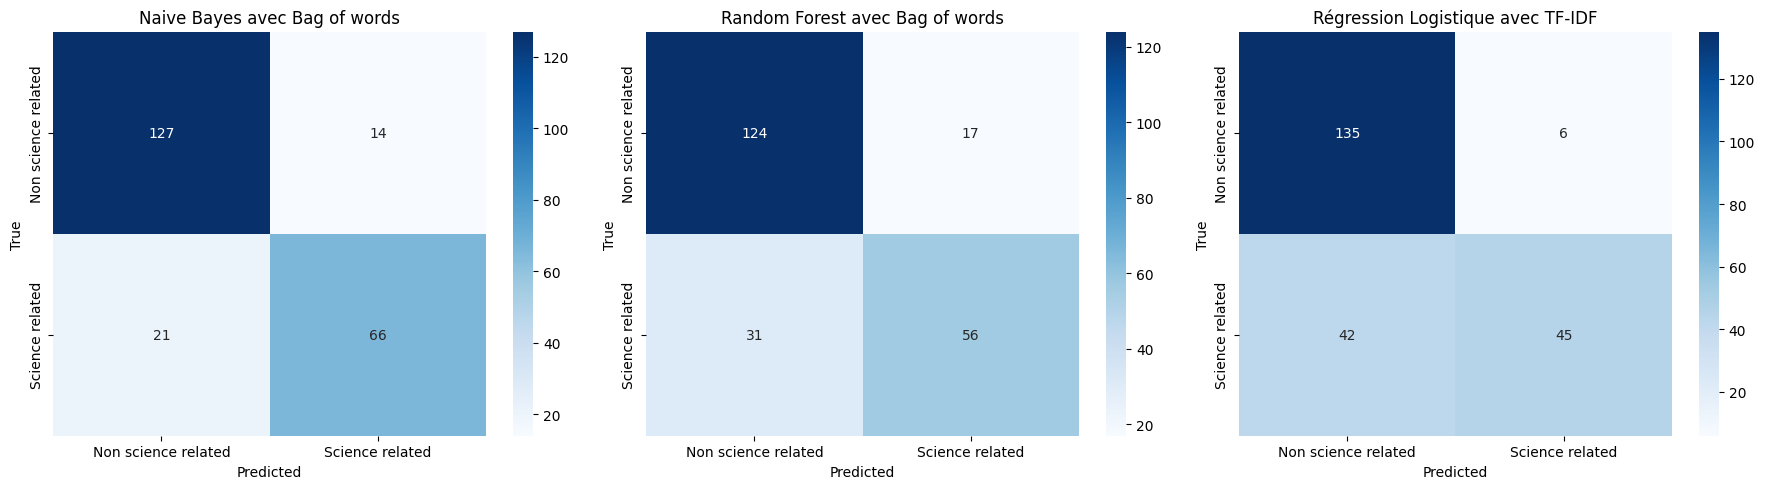

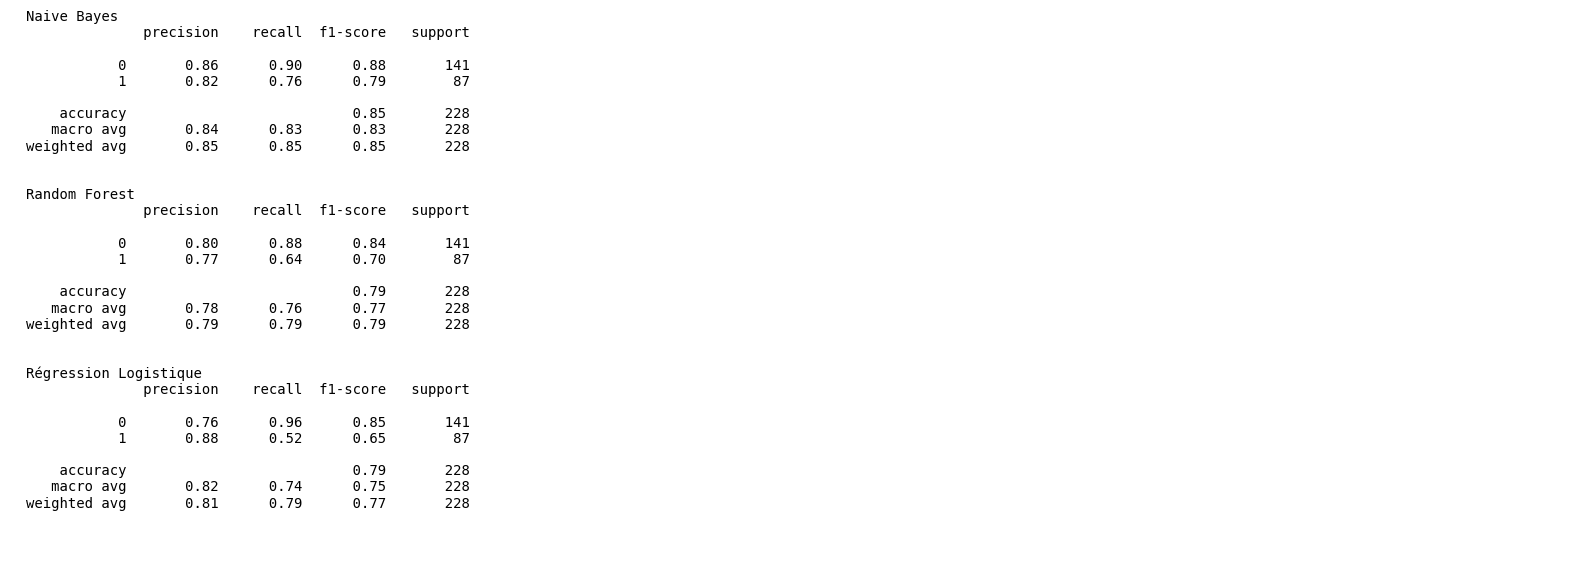

✅ Results saved to: ../../results/Step 1


In [153]:
# --- CM ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
	("Naive Bayes_Bag of words", "Naive Bayes avec Bag of words"),
	("Random Forest_Bag of words", "Random Forest avec Bag of words"),
	("Régression Logistique_TF-IDF", "Régression Logistique avec TF-IDF")
]

for ax, (key, title) in zip(axes, models):
	sns.heatmap(results[key]['confusion_matrix'], annot=True, fmt="d", cmap="Blues", 
				xticklabels=["Non science related", "Science related"],
				yticklabels=["Non science related", "Science related"], ax=ax)
	ax.set_title(title)
	ax.set_xlabel("Predicted")
	ax.set_ylabel("True")

plt.tight_layout()
plt.show()

# --- TEXT REPORTS ---
fig, ax = plt.subplots(figsize=(16, 6))
ax.axis("off")  # cache les axes

report_texts = [
	("Naive Bayes", results["Naive Bayes_Bag of words"]['class_report']),
	("Random Forest", results["Random Forest_Bag of words"]['class_report']),
	("Régression Logistique", results["Régression Logistique_TF-IDF"]['class_report'])
]

text_combined = ""
for name, report in report_texts:
	text_combined += f"{name}\n" + report + "\n\n"

ax.text(0.01, 1, text_combined, fontsize=10, fontfamily='monospace', va='top')

plt.tight_layout()
plt.show()


save_result(
	title="Comparaison des matrices de confusion",
	description="Ce graphique compare les performances de trois modèles sur un jeu de données binaire : Naive Bayes, Random Forest, et Régression Logistique.",
	fig=fig,
	output_dir = os.path.join(config.result_dir, "Step 1"),
	static_dir = config.static_dir
)

# Tuning des hyperparamètres des 3 classifiers

In [154]:
def show_pca(matrix, labels, title: str):
	pca = PCA(n_components=4)
	X_pca = pca.fit_transform(matrix)

	df = pd.DataFrame({
		'PC1': X_pca[:, 0],
		'PC2': X_pca[:, 1],
		'label': labels
	})

	sns.scatterplot(data=df, x='PC1', y='PC2', hue='label')
	plt.title(title)
	plt.grid(True)
	plt.show()

def get_score(y_test, y_pred):
	test_f1 = f1_score(y_test, y_pred, average='macro')
	print(f"F1 macro (test set): {test_f1:.4f}")


1. Naive Bayes avec Bag of words

In [155]:
numerical_cols = X_train.select_dtypes(include='number').columns.tolist()

def objective(trial):
	ngram_options = {
		"unigram": (1, 1),
		"bigram": (1, 2),
		"trigram": (1, 3),
		"quadrugram": (1, 4)
	}

	alpha = trial.suggest_float("alpha", 0.01, 1.5, log=True)
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 5)
	max_features = trial.suggest_categorical("max_features", [1000, 5000, 10000])

	text_vectorizer = CountVectorizer(
		ngram_range=ngram_options[ngram_key],
		min_df=min_df,
		max_features=max_features
	)

	preprocessor = ColumnTransformer(
		transformers=[
			("text", text_vectorizer, "text"),
			("num", "passthrough", numerical_cols)
		]
	)

	pipeline = Pipeline([
		("preprocessor", preprocessor),
		("classifier", MultinomialNB(alpha=alpha))
	])

	kfold = KFold(n_splits=3, shuffle=True, random_state=config.random_state)
	score = cross_val_score(pipeline, X=X_train, y=y_train, cv=kfold, scoring='f1_macro').mean()

	return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)



[I 2025-05-04 12:49:30,886] A new study created in memory with name: no-name-78bcbef5-3faf-4938-a39c-e396d2db5f04
[I 2025-05-04 12:49:31,151] Trial 0 finished with value: 0.7563364474590134 and parameters: {'alpha': 0.9873519198988044, 'ngram_range': 'trigram', 'min_df': 1, 'max_features': 5000}. Best is trial 0 with value: 0.7563364474590134.
[I 2025-05-04 12:49:31,302] Trial 1 finished with value: 0.7650985328108274 and parameters: {'alpha': 0.26336800531404325, 'ngram_range': 'bigram', 'min_df': 3, 'max_features': 5000}. Best is trial 1 with value: 0.7650985328108274.
[I 2025-05-04 12:49:31,400] Trial 2 finished with value: 0.7573235176101264 and parameters: {'alpha': 0.4442030739243889, 'ngram_range': 'unigram', 'min_df': 3, 'max_features': 10000}. Best is trial 1 with value: 0.7650985328108274.
[I 2025-05-04 12:49:31,572] Trial 3 finished with value: 0.7673286119215558 and parameters: {'alpha': 0.08573097244640192, 'ngram_range': 'bigram', 'min_df': 2, 'max_features': 10000}. Best

In [ ]:
print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)

config.save_model("NB", study.best_params)

Best f1_macro: 0.7794293064266117
Best params: {'alpha': 0.5907316408639203, 'ngram_range': 'quadrugram', 'min_df': 2, 'max_features': 5000}


On ajoute ce modele dans le config file

In [161]:
model = config.get_model("NB")
vectorizer = model.get_vectorizer()

text_col = "text"
numerical_cols = X_train.select_dtypes(include='number').columns.tolist()

preprocessor = ColumnTransformer(
	transformers=[
		("text", vectorizer, text_col),
		("num", "passthrough", numerical_cols)
	]
)

pipeline = Pipeline([
	("preprocessor", preprocessor),
	("classifier", MultinomialNB(alpha=model.get_config("alpha")))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

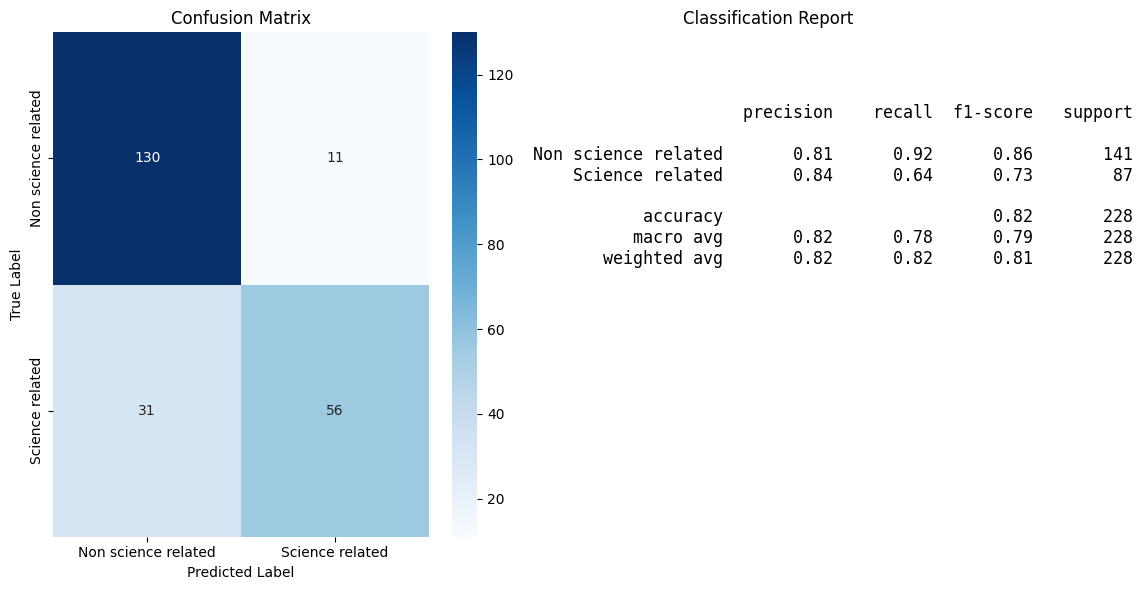

F1 macro (test set): 0.7941
✅ Results saved to: ../../results/Step 1/Naive Bayes


In [162]:
fig = display_result(y_pred, y_test)

get_score(y_test, y_pred)

save_result(
	title="Rapport du Naive Bayes avec BoW (3 eme essaie)",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna",
    fig=fig,
	output_dir = os.path.join(config.result_dir, "Step 1", "Naive Bayes"),
	static_dir = config.static_dir
)

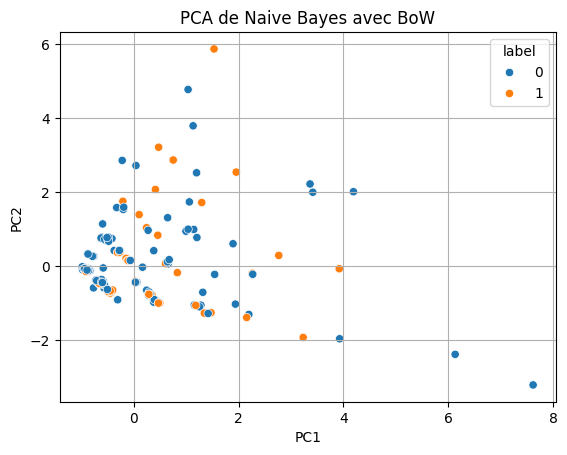

In [ ]:

X_test_transformed = pipeline.named_steps["preprocessor"].transform(X_test)

show_pca(X_test_transformed.toarray(), y_test.values, "PCA de Naive Bayes avec BoW")

2. Random Forest avec Bag of words

In [ ]:
def objective(trial):
	# Définir les plages de n-grammes
	ngram_options = {
		"unigram": (1, 1),
		"bigram": (1, 2),
		"trigram": (1, 3),
		"quadrugram": (1, 4)
	}

	# Hyperparamètres texte
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 5)
	max_features = trial.suggest_categorical("max_features", [1000, 5000, 10000])

	# Hyperparamètres Random Forest
	n_estimators = trial.suggest_int("n_estimators", 100, 300)
	max_depth = trial.suggest_int("max_depth", 5, 25)
	min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
	min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)

	text_vectorizer = CountVectorizer(
		ngram_range=ngram_options[ngram_key],
		min_df=min_df,
		max_features=max_features
	)

	preprocessor = ColumnTransformer(
		transformers=[
			("text", text_vectorizer, "text"),
			("num", "passthrough", numerical_cols)
		]
	)

	classifier = RandomForestClassifier(
		n_estimators=n_estimators,
		max_depth=max_depth,
		min_samples_split=min_samples_split,
		min_samples_leaf=min_samples_leaf,
		random_state=config.random_state,
		class_weight='balanced'
	)

	pipeline = Pipeline([
		("preprocessor", preprocessor),
		("classifier", classifier)
	])

	kfold = KFold(n_splits=3, shuffle=True, random_state=config.random_state)
	score = cross_val_score(pipeline, X=X_train, y=y_train, cv=kfold, scoring='f1_macro').mean()

	return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)


[I 2025-05-03 22:30:34,554] A new study created in memory with name: no-name-7f797306-ec99-4656-8e82-272c26f033b3
[I 2025-05-03 22:30:36,043] Trial 0 finished with value: 0.751495128137063 and parameters: {'ngram_range': 'unigram', 'min_df': 2, 'max_features': 5000, 'n_estimators': 205, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.751495128137063.
[I 2025-05-03 22:30:36,676] Trial 1 finished with value: 0.7307160237649555 and parameters: {'ngram_range': 'unigram', 'min_df': 3, 'max_features': 5000, 'n_estimators': 105, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.751495128137063.
[I 2025-05-03 22:30:37,745] Trial 2 finished with value: 0.7427747064594529 and parameters: {'ngram_range': 'quadrugram', 'min_df': 2, 'max_features': 10000, 'n_estimators': 133, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.751495128137063.
[I 2025-05-03 22:30:38,

In [ ]:
print("✅ Best f1_macro:", study.best_value)
print("🏆 Best hyperparameters:", study.best_params)

config.save_model("RandomForest", study.best_params)

✅ Best f1_macro: 0.7516711787290723
🏆 Best hyperparameters: {'ngram_range': 'trigram', 'min_df': 4, 'max_features': 5000, 'n_estimators': 223, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 1}


In [165]:
model = config.get_model("RandomForest")
vectorizer = model.get_vectorizer()

preprocessor = ColumnTransformer(
	transformers=[
		("text", vectorizer, text_col),
		("num", "passthrough", numerical_cols)
	]
)

pipeline = Pipeline([
	("preprocessor", preprocessor),
	("classifier",  RandomForestClassifier(
		n_estimators = model.get_config("n_estimators"),
		max_depth = model.get_config("max_depth"),
		min_samples_split = model.get_config("min_samples_split"),
		min_samples_leaf = model.get_config("min_samples_leaf"),
		random_state = config.random_state,
		class_weight='balanced'
	))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

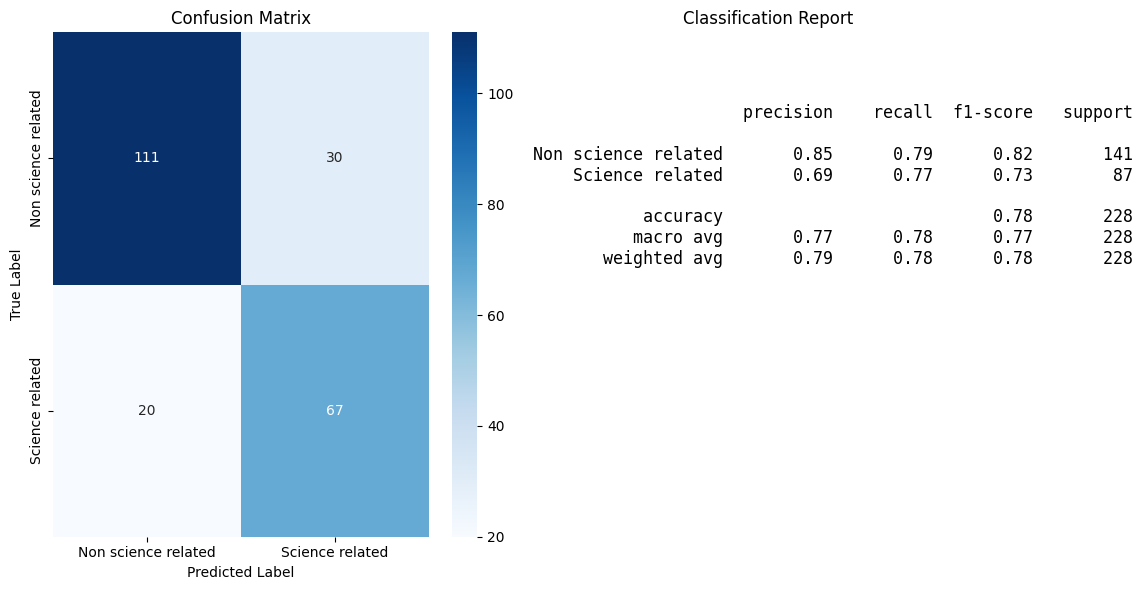

✅ Results saved to: ../../results/Step 1/RandomForest


In [166]:
fig = display_result(y_pred, y_test)

save_result(
	title="Rapport du Random Forest avec BoW",
	description="Ce graphique montre le résultats hyperparamètrique avec optuna",
	fig=fig,
	output_dir = os.path.join(config.result_dir, "Step 1", "RandomForest"),
	static_dir = config.static_dir
)

3. Regression Logistique avec TF-IDF

In [ ]:
def objective(trial):
    # Définir les plages de n-grammes
    ngram_options = {
        "unigram": (1, 1),
        "bigram": (1, 2),
        "trigram": (1, 3),
        "quadrugram": (1, 4)
    }

    # Hyperparamètres texte
    ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
    min_df = trial.suggest_int("min_df", 1, 5)
    max_features = trial.suggest_categorical("max_features", [1000, 5000, 10000])

    # Hyperparamètres Logistic Regression
    C = trial.suggest_float("C", 1e-3, 10.0, log=True)
    penalty = trial.suggest_categorical("penalty", ["l2"])
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

    text_vectorizer = TfidfVectorizer(
        ngram_range=ngram_options[ngram_key],
        min_df=min_df,
        max_features=max_features
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("text", text_vectorizer, "text"),
            ("num", "passthrough", numerical_cols)
        ]
    )

    classifier = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        random_state=config.random_state,
        class_weight='balanced',
        max_iter=2000
    )

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", classifier)
    ])

    kfold = KFold(n_splits=3, shuffle=True, random_state=config.random_state)
    score = cross_val_score(pipeline, X=X_train, y=y_train, cv=kfold, scoring='f1_macro').mean()

    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

[I 2025-05-03 22:38:39,063] A new study created in memory with name: no-name-448ee614-9b82-44b2-8388-900e03dffb52
[I 2025-05-03 22:38:39,212] Trial 0 finished with value: 0.7740172691851153 and parameters: {'ngram_range': 'unigram', 'min_df': 5, 'max_features': 10000, 'C': 1.4939428207787313, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.7740172691851153.
[I 2025-05-03 22:38:39,590] Trial 1 finished with value: 0.7452659529273964 and parameters: {'ngram_range': 'quadrugram', 'min_df': 5, 'max_features': 1000, 'C': 0.4443306180141614, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.7740172691851153.
[I 2025-05-03 22:38:39,835] Trial 2 finished with value: 0.7683972907090272 and parameters: {'ngram_range': 'trigram', 'min_df': 4, 'max_features': 5000, 'C': 1.3511239395149495, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.7740172691851153.
[I 2025-05-03 22:38:40,017] Trial 3 finished with value: 0.6511089932918775 an

In [ ]:
print("✅ Best f1_macro:", study.best_value)
print("🏆 Best hyperparameters:", study.best_params)

config.save_model("LogisticRegression", study.best_params)

✅ Best f1_macro: 0.7761842140508112
🏆 Best hyperparameters: {'ngram_range': 'unigram', 'min_df': 1, 'max_features': 10000, 'C': 4.602421202481325, 'penalty': 'l2', 'solver': 'saga'}


In [169]:
model = config.get_model("LogisticRegression")
vectorizer = model.get_vectorizer()

preprocessor = ColumnTransformer(
	transformers=[
		("text", vectorizer, text_col),
		("num", "passthrough", numerical_cols)
	]
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        C = model.get_config("C"),
        penalty = model.get_config("penalty"),
        solver = model.get_config("solver"),
        class_weight = "balanced",
        random_state = config.random_state,
        max_iter = 2000
    ))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

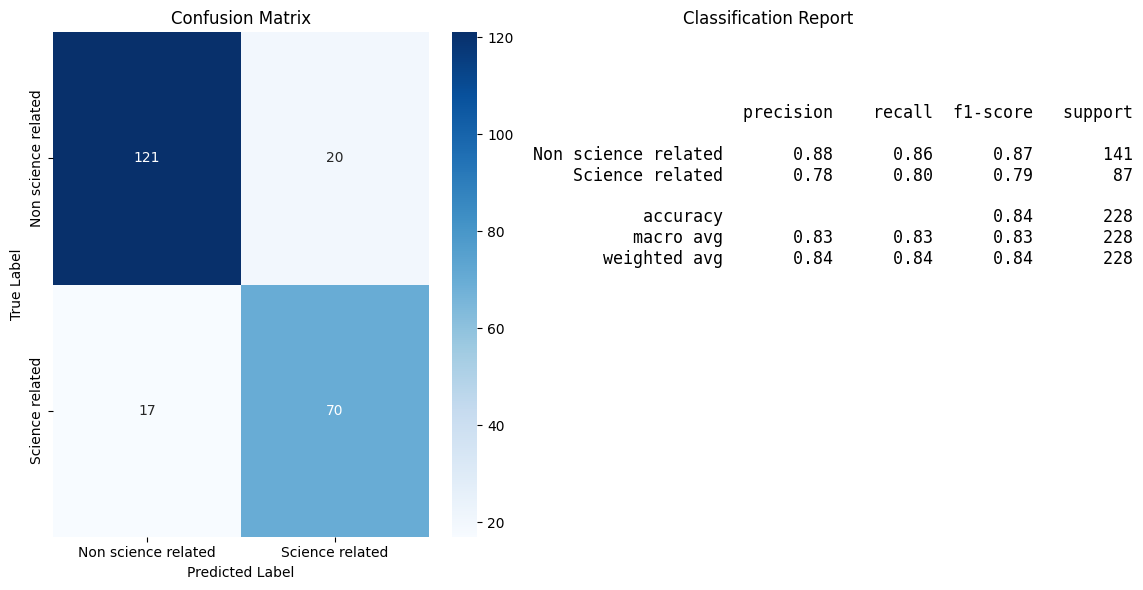

✅ Results saved to: ../../results/Step 1/Regression Logistique


In [170]:
fig = display_result(y_pred, y_test)

save_result(
	title="Rapport du Regression Logistique avec TF-IDF",
	description="Ce graphique montre le résultats hyperparamètrique avec optuna",
	fig=fig,
	output_dir = os.path.join(config.result_dir, "Step 1", "Regression Logistique"),
	static_dir = config.static_dir
)